# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [1]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [2]:
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)
api_key = getpass()

In [ ]:
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=364)  # 1 year later

# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date:
    next_date = min(current_date + timedelta(days=7), end_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date + timedelta(days=1) #Incremented current_date by a day. Necessary to prevent overlap
    time.sleep(1)  # To avoid hitting the rate limit

# Now 'data' contains the NEO data for the 1-year period

In [10]:
# Check the date coverage of your data.
dates_contained_in_data = []
for d in data:
    dates_contained_in_data += list(d['near_earth_objects'].keys())

print(sorted(dates_contained_in_data))

['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08', '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28', '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01', '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05', '2022-02-06', '2022-02-07', '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11', '2022-02-12', '2022-02-13', '2022-02-14', '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18', '2022-02-19', '2022-02-20', '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24', '2022-02-25', '2022-02-26', '2022-02-27', '2022-02-28', '2022-03-01', '2022-03-02', '2022-03-03', '2022-03-04', '2022-03-05', '2022-03-06', '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11', '2022-03-12', '2022

In [120]:
from src.utils import get_a_random_chunk_property
get_a_random_chunk_property(data)

For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

In [8]:
#Save to pickle
import pickle
with open('NASAdata_raw.pkl', 'wb') as f:
    pickle.dump(data, f)

In [19]:
#Import from pickle
import pickle
with open('NASAdata_raw.pkl', 'rb') as f:
    data = pickle.load(f)

In [20]:
import pandas as pd
temp_dfs = []   #Create a temp list to store all the dataframe we are going to generate

for d in data:      #The way the data is saved to a list leaves it in pieces that we have to go over
    for day in d['near_earth_objects']:
        subset = d['near_earth_objects'][day]   #We take a subset consisting of all object logged that day
        df_temp = pd.json_normalize(subset)     #Turn the subset into a dataframe
        df_temp2 = pd.json_normalize(subset, record_path='close_approach_data') #Normalize doesn't catch close_approach_data for some reason, so we single that out too
        df_temp = pd.concat([df_temp, df_temp2], axis=1) #Combine the two temp dataframes
        df_temp = df_temp[['id',        #Retrieve the columns we want
                           'name',
                           'absolute_magnitude_h',
                           'estimated_diameter.meters.estimated_diameter_min', #meters
                           'estimated_diameter.meters.estimated_diameter_max', #meters
                           'is_potentially_hazardous_asteroid',
                           'close_approach_date_full',
                           'relative_velocity.kilometers_per_second',   #kilometers per second
                           'miss_distance.kilometers',      #kilometers
                           'miss_distance.lunar',
                           'orbiting_body',
                           'is_sentry_object']]
        df_temp.rename(columns={'estimated_diameter.meters.estimated_diameter_min': 'estimated_diameter_min (m)',
                                'estimated_diameter.meters.estimated_diameter_max': 'estimated_diameter_max (m)',
                                'relative_velocity.kilometers_per_second': 'relative_velocity (km/s)',
                                'miss_distance.kilometers': 'miss_distance (km)',
                                'miss_distance.lunar': 'miss_distance (lunar)',
                                'is_potentially_hazardous_asteroid': 'potentially_hazardous'}, inplace=True)
        df_temp['date'] = day       #Save the date in a new column
        orderedColumns = ['date', 'id', 'name', 'absolute_magnitude_h', 'estimated_diameter_min (m)',
                          'estimated_diameter_max (m)', 'potentially_hazardous',
                          'close_approach_date_full', 'relative_velocity (km/s)',
                          'miss_distance (km)', 'orbiting_body', 'is_sentry_object',
                          'miss_distance (lunar)']
        df_temp = df_temp.reindex(columns=orderedColumns)   #Rearrange the columns
        temp_dfs.append(df_temp)    #Save the dataframe in a temp list

df = pd.concat(temp_dfs, ignore_index=True)     #Combine all the saved dataframes
df = df.sort_values('date')

velocity_float = []     #Make relative_velocity a float
for string in df['relative_velocity (km/s)']:
    velocity_float.append(float(string))
df['relative_velocity (km/s)'] = velocity_float

distance_float = []     #Make miss_distance a float
for string in df['miss_distance (lunar)']:
    distance_float.append(float(string))
df['miss_distance (lunar)'] = distance_float

df

,date,id,name,absolute_magnitude_h,estimated_diameter_min (m),estimated_diameter_max (m),potentially_hazardous,close_approach_date_full,relative_velocity (km/s),miss_distance (km),orbiting_body,is_sentry_object,miss_distance (lunar)
50,2022-01-01,3592308,(2012 AP10),26.50,13.321557,29.787906,False,2022-Jan-01 18:51,15.995934,59408029.872013471,Earth,False,154.478962
47,2022-01-01,2376848,376848 (2001 RY47),19.61,318.093633,711.278987,False,2022-Jan-01 21:17,17.701016,51175408.449642073,Earth,False,133.071640
48,2022-01-01,2488490,488490 (2000 AF205),21.90,110.803882,247.765013,True,2022-Jan-01 15:49,21.077399,60914169.094786214,Earth,False,158.395382
49,2022-01-01,3388081,(2007 TL23),21.48,134.448195,300.635304,True,2022-Jan-01 17:46,31.100974,29572825.360666295,Earth,False,76.898348
51,2022-01-01,3744561,(2016 CN248),27.30,9.216265,20.608196,False,2022-Jan-01 20:11,10.698308,60839595.828173109,Earth,False,158.201469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,2022-12-31,3942363,(2019 YL),25.55,20.632648,46.136004,False,2022-Dec-31 23:17,9.936890,21928989.095791356,Earth,False,57.022047
2669,2022-12-31,3989139,(2020 BW5),26.41,13.885291,31.048454,False,2022-Dec-31 09:41,6.210175,62348309.884604931,Earth,False,162.124585
2670,2022-12-31,3989355,(2020 CB),27.70,7.665756,17.141151,False,2022-Dec-31 01:10,4.478350,27830701.407084417,Earth,False,72.368295
2661,2022-12-31,3005973,(1995 CR),21.74,119.276525,266.710417,True,2022-Dec-31 12:07,30.961163,11290881.810098145,Earth,False,29.359730


In [21]:
#Save to pickle
import pickle
with open('NASAdata_df.pkl', 'wb') as f:
    pickle.dump(df, f)

In [22]:
#Import from pickle
import pickle
with open('NASAdata_df.pkl', 'rb') as f:
    df = pickle.load(f)
df
#TODO: missing 2022-05-26

,date,id,name,absolute_magnitude_h,estimated_diameter_min (m),estimated_diameter_max (m),potentially_hazardous,close_approach_date_full,relative_velocity (km/s),miss_distance (km),orbiting_body,is_sentry_object,miss_distance (lunar)
50,2022-01-01,3592308,(2012 AP10),26.50,13.321557,29.787906,False,2022-Jan-01 18:51,15.995934,59408029.872013471,Earth,False,154.478962
47,2022-01-01,2376848,376848 (2001 RY47),19.61,318.093633,711.278987,False,2022-Jan-01 21:17,17.701016,51175408.449642073,Earth,False,133.071640
48,2022-01-01,2488490,488490 (2000 AF205),21.90,110.803882,247.765013,True,2022-Jan-01 15:49,21.077399,60914169.094786214,Earth,False,158.395382
49,2022-01-01,3388081,(2007 TL23),21.48,134.448195,300.635304,True,2022-Jan-01 17:46,31.100974,29572825.360666295,Earth,False,76.898348
51,2022-01-01,3744561,(2016 CN248),27.30,9.216265,20.608196,False,2022-Jan-01 20:11,10.698308,60839595.828173109,Earth,False,158.201469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,2022-12-31,3942363,(2019 YL),25.55,20.632648,46.136004,False,2022-Dec-31 23:17,9.936890,21928989.095791356,Earth,False,57.022047
2669,2022-12-31,3989139,(2020 BW5),26.41,13.885291,31.048454,False,2022-Dec-31 09:41,6.210175,62348309.884604931,Earth,False,162.124585
2670,2022-12-31,3989355,(2020 CB),27.70,7.665756,17.141151,False,2022-Dec-31 01:10,4.478350,27830701.407084417,Earth,False,72.368295
2661,2022-12-31,3005973,(1995 CR),21.74,119.276525,266.710417,True,2022-Dec-31 12:07,30.961163,11290881.810098145,Earth,False,29.359730


### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [23]:
# Write your code
from IPython.display import display

# Average size per day
print("Average size of NEOs per day:")
display(df.groupby('date')[['estimated_diameter_min (m)', 'estimated_diameter_max (m)']].mean())

# Proportion that are potentially hazardous
print("Proportion of NEOs that are potentially hazardous:")
df1 = df['potentially_hazardous'].value_counts(normalize=True) #Note: This returns a series
display(pd.DataFrame(df1))

# Closest approach per day
closest_NEOs = df.groupby('date')['miss_distance (lunar)'].min()  #Find the minimum values for each day
df1 = df.merge(closest_NEOs, on='date', suffixes=('', ' (min)'))   #Add the values as an extra row
df1 = df1[df1['miss_distance (lunar)'] == df1['miss_distance (lunar) (min)']]    #Pick out the rows were the distance matches the minimum distance
print("The NEOs with the closest approach distance each day:")
display(df1[['date', 'id', 'name', 'miss_distance (lunar)']]) #Show only the relevant columns

# Statistical analysis of the data
print("Standard statistical analysis:")
df1 = df.copy()

velocity_float = []     #Make relative_velocity a float
for string in df['relative_velocity (km/s)']:
    velocity_float.append(float(string))
df1['relative_velocity (km/s)'] = velocity_float

distance_float = []     #Make miss_distance a float
for string in df['miss_distance (lunar)']:
    distance_float.append(float(string))
df1['miss_distance (lunar)'] = distance_float

df1_desc = df1.describe()

df2 = df1.round()   #Round the numbers and find mode
df2 = df2[['absolute_magnitude_h', 'estimated_diameter_min (m)', 'estimated_diameter_max (m)', 'relative_velocity (km/s)', 'miss_distance (lunar)']].mode().copy()
df1_desc.loc[len(df.index)] = df2.values[0]
df1_desc.index.values[8] = 'mode (rounded)'
df1_desc.index.values[5] = 'median'

display(df1_desc.iloc[[1, 2, 3, 5, 7, 8]]) #Show mean, std, min, median, max, mode

#Correlation between NEO size and hazard potential
print("Correlation between NEO size and its potential to be a hazard:")
print()
print("Mean diameter by hazard potential:")
display(df.groupby('potentially_hazardous')[['estimated_diameter_min (m)', 'estimated_diameter_max (m)']].mean())
print("The 1500 objects with smallest maximum diameter:")
display(pd.DataFrame(df.sort_values('estimated_diameter_max (m)')[:1500]['potentially_hazardous'].value_counts())) #1500 smallest
print("The 1000 objects with greatest maximum diameter:")
display(pd.DataFrame(df.sort_values('estimated_diameter_max (m)')[-1000:]['potentially_hazardous'].value_counts())) #1000 largest
print("It is obvious that there is a correlation between the size of an object and its potential to be a hazard. Of the roughly 2700 objects logged, none in the lower half of the data set was flagged as a potential hazard, while up to a third of the largest objects were flagged.")

Average size of NEOs per day:


,estimated_diameter_min (m),estimated_diameter_max (m)
date,,
2022-01-01,137.285374,306.979428
2022-01-02,44.368082,99.210048
2022-01-03,13.808840,30.877505
2022-01-04,57.882309,129.428778
2022-01-05,182.616732,408.343426
...,...,...
2022-12-27,244.396709,546.487654
2022-12-28,165.747447,370.622559
2022-12-29,155.066983,346.740315


Proportion of NEOs that are potentially hazardous:


,proportion
potentially_hazardous,
False,0.864248
True,0.135752


The NEOs with the closest approach distance each day:


,date,id,name,miss_distance (lunar)
13,2022-01-01,3836179,(2018 VB7),61.337745
14,2022-01-02,3625335,(2013 BC70),55.091963
20,2022-01-03,3986680,(2020 AL3),132.030159
22,2022-01-04,3780740,(2017 QW1),53.340989
29,2022-01-05,3365921,(2007 AM),72.990854
...,...,...,...,...
2635,2022-12-27,3553169,(2010 XC15),2.008254
2649,2022-12-28,3525129,(2010 KV39),56.819337
2654,2022-12-29,3837867,(2019 AX11),38.606948
2661,2022-12-30,3367130,(2007 BB49),144.123374


Standard statistical analysis:


,absolute_magnitude_h,estimated_diameter_min (m),estimated_diameter_max (m),relative_velocity (km/s),miss_distance (lunar)
mean,22.879068,164.607334,368.073189,14.430863,114.663061
std,2.971990,253.652908,567.185144,7.085677,51.810334
min,14.670000,1.214940,2.716689,0.536816,1.784416
median,22.705000,76.481453,171.017727,13.715671,118.694940
max,31.700000,3094.246986,6918.946600,52.005854,194.480567
mode (rounded),21.000000,13.000000,36.000000,9.000000,185.000000


Correlation between NEO size and its potential to be a hazard:

Mean diameter by hazard potential:


,estimated_diameter_min (m),estimated_diameter_max (m)
potentially_hazardous,,
False,143.430686,320.720763
True,299.426163,669.537255


The 1500 objects with smallest maximum diameter:


,count
potentially_hazardous,
False,1500


The 1000 objects with greatest maximum diameter:


,count
potentially_hazardous,
False,684
True,316


It is obvious that there is a correlation between the size of an object and its potential to be a hazard. Of the roughly 2700 objects logged, none in the lower half of the data set was flagged as a potential hazard, while up to a third of the largest objects were flagged.


### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

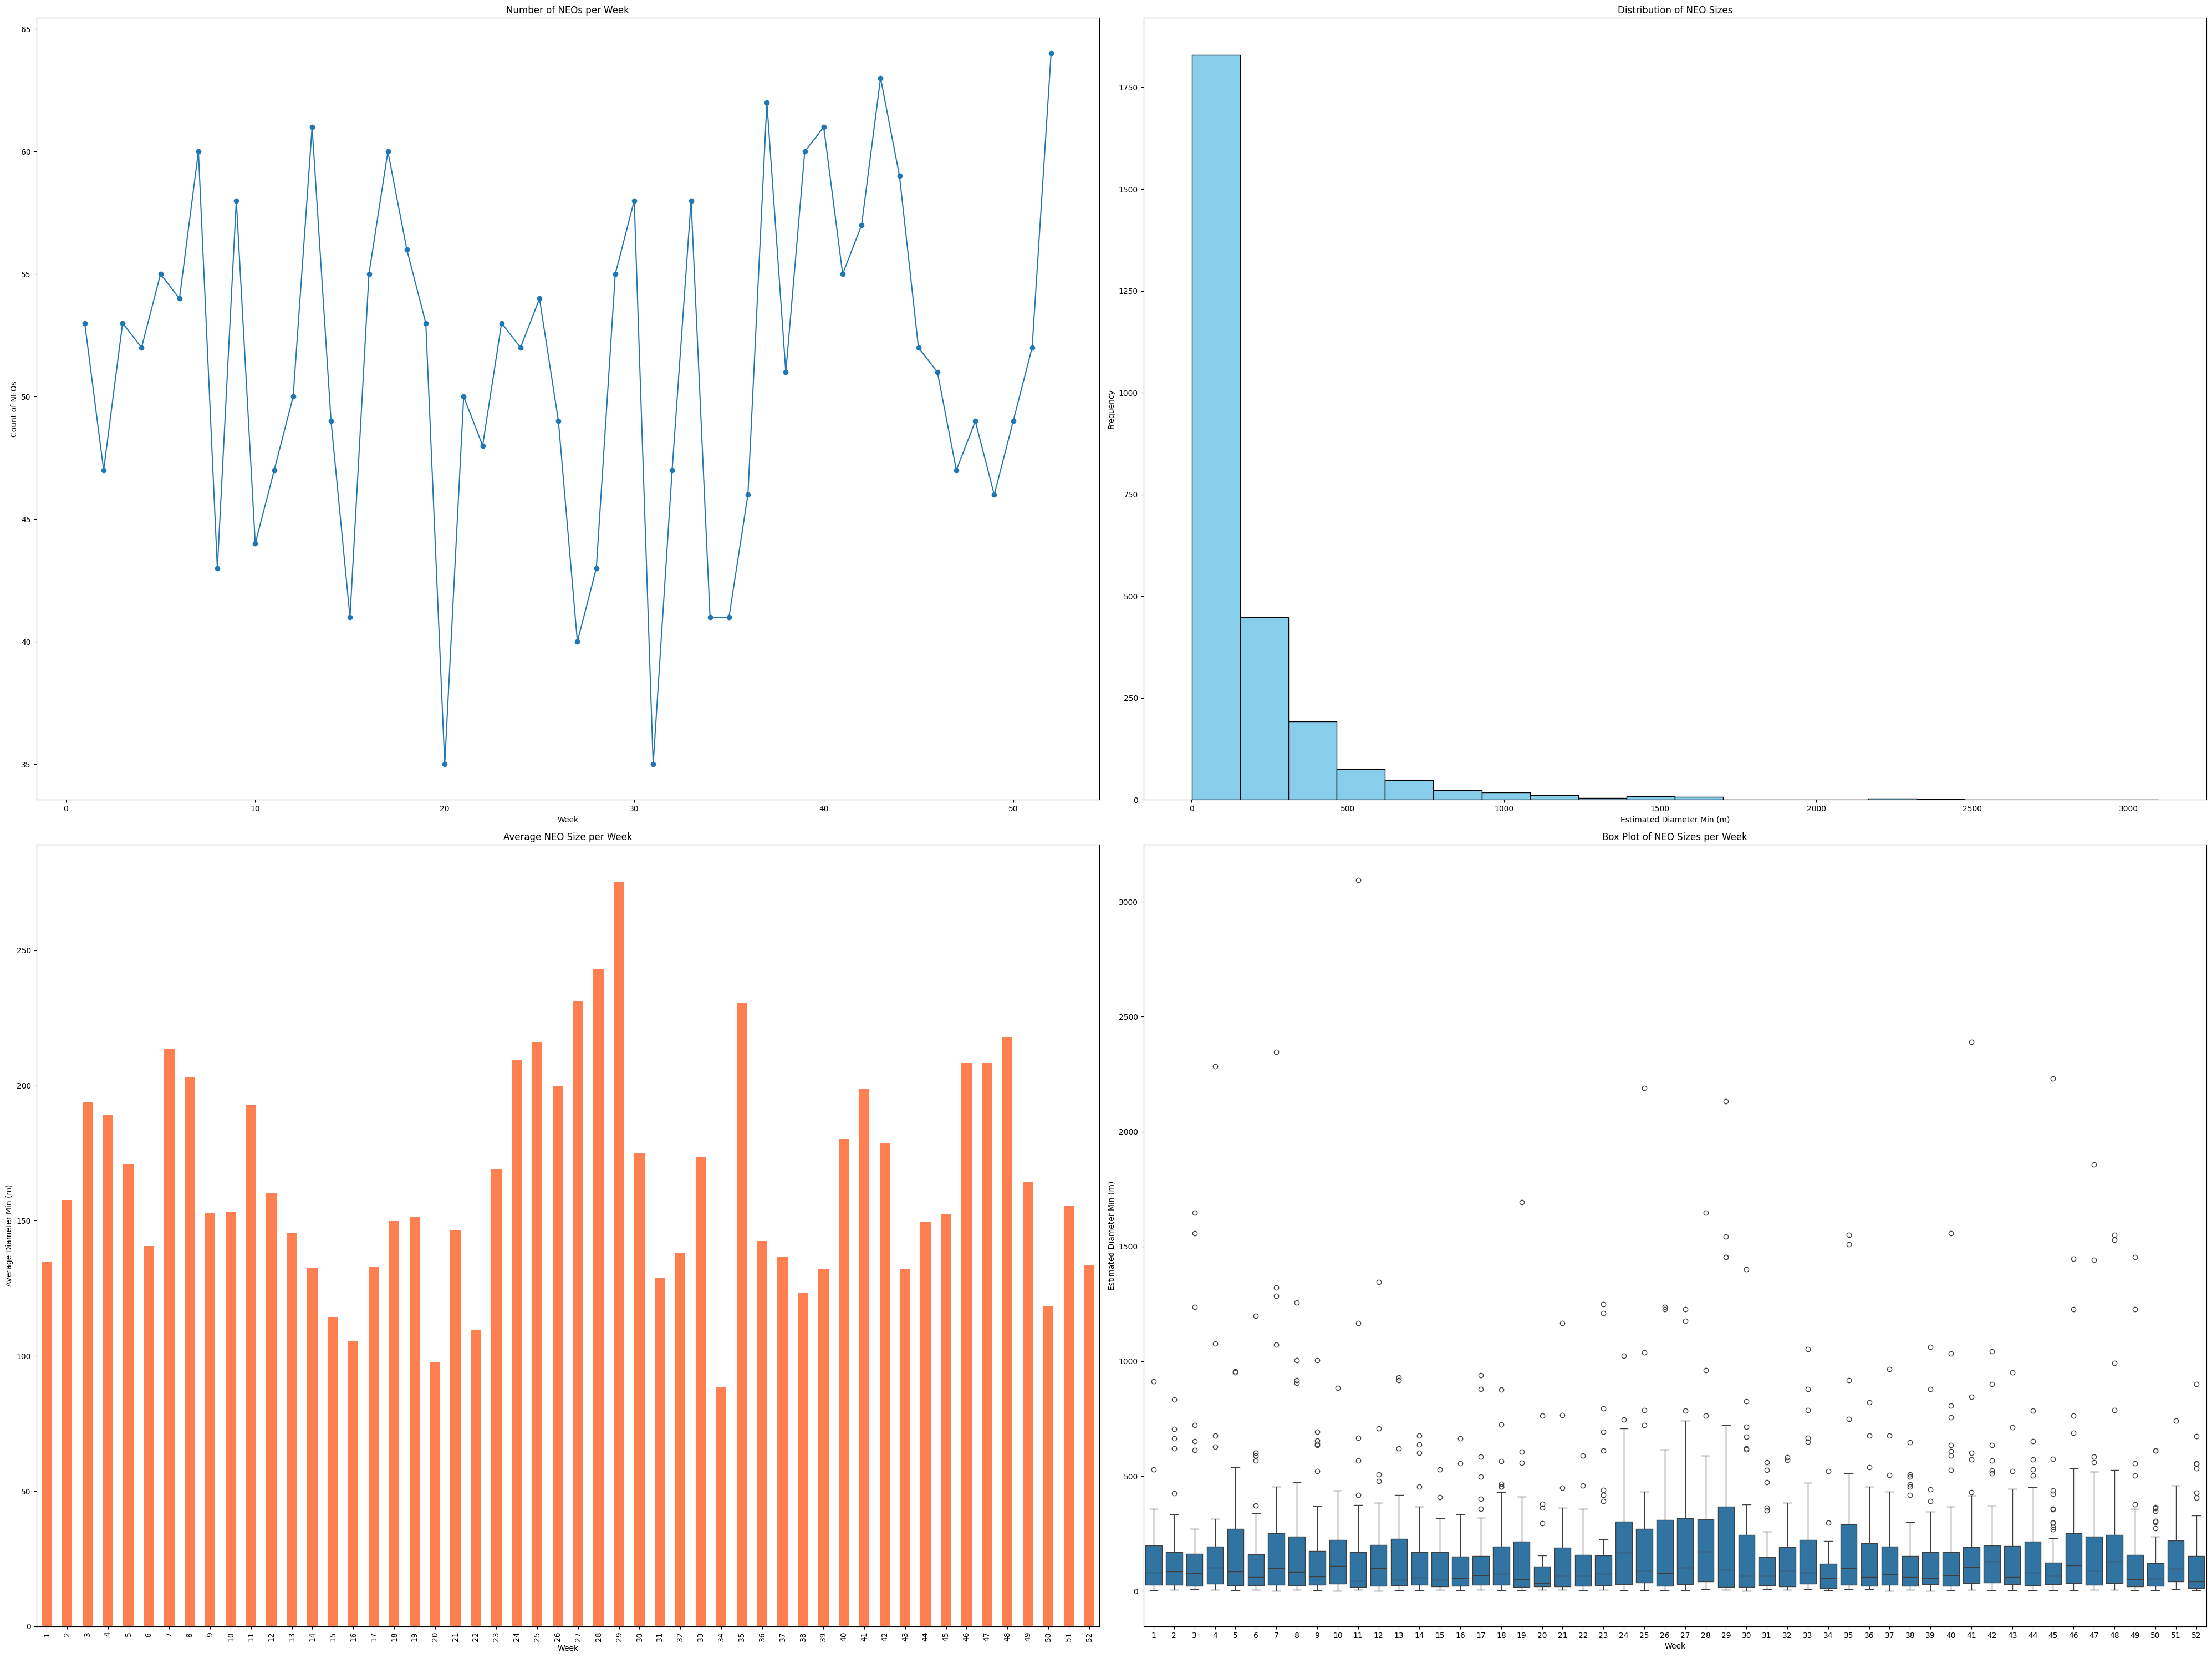

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import pickle

# Convert 'date' column to datetime and extract the week number
df['week'] = pd.to_datetime(df['close_approach_date_full']).dt.isocalendar().week

plt.figure(figsize=(40, 30))

# Group by 'week' and count unique 'id' for the number of NEOs per week
neos_per_week = df.groupby('week')['id'].nunique()

# Line plot for the number of NEOs per week
plt.subplot(2, 2, 1)
neos_per_week.plot(kind='line', marker='o')
plt.title('Number of NEOs per Week')
plt.xlabel('Week')
plt.ylabel('Count of NEOs')

# Histogram for the distribution of NEO sizes
sizes = df['estimated_diameter_min (m)']
plt.subplot(2, 2, 2)
plt.hist(sizes, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of NEO Sizes')
plt.xlabel('Estimated Diameter Min (m)')
plt.ylabel('Frequency')

# Bar plot for the average NEO size per week
average_size_per_week = df.groupby('week')['estimated_diameter_min (m)'].mean()
plt.subplot(2, 2, 3)
average_size_per_week.plot(kind='bar', color='coral')
plt.title('Average NEO Size per Week')
plt.xlabel('Week')
plt.ylabel('Average Diameter Min (m)')

# Box plot of NEO sizes using Seaborn
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='week', y='estimated_diameter_min (m)')
plt.title('Box Plot of NEO Sizes per Week')
plt.xlabel('Week')
plt.ylabel('Estimated Diameter Min (m)')

# Adjust layout to prevent overlap and show plots
plt.tight_layout()
plt.show()


### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

C:\Users\oscar\AppData\Local\Temp\ipykernel_14460\1781657561.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'non-hazardous' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



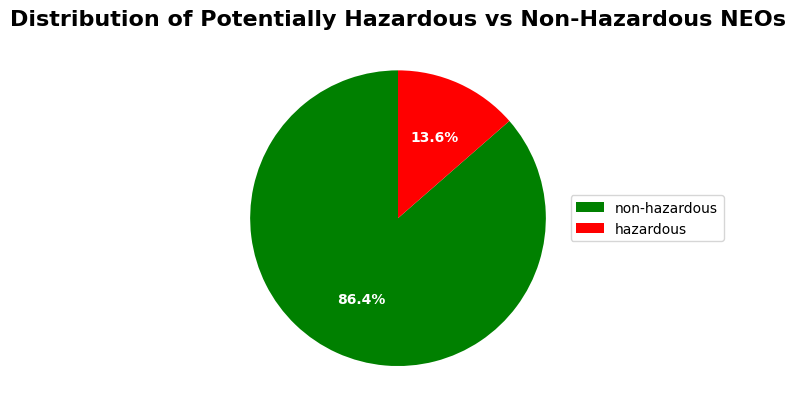

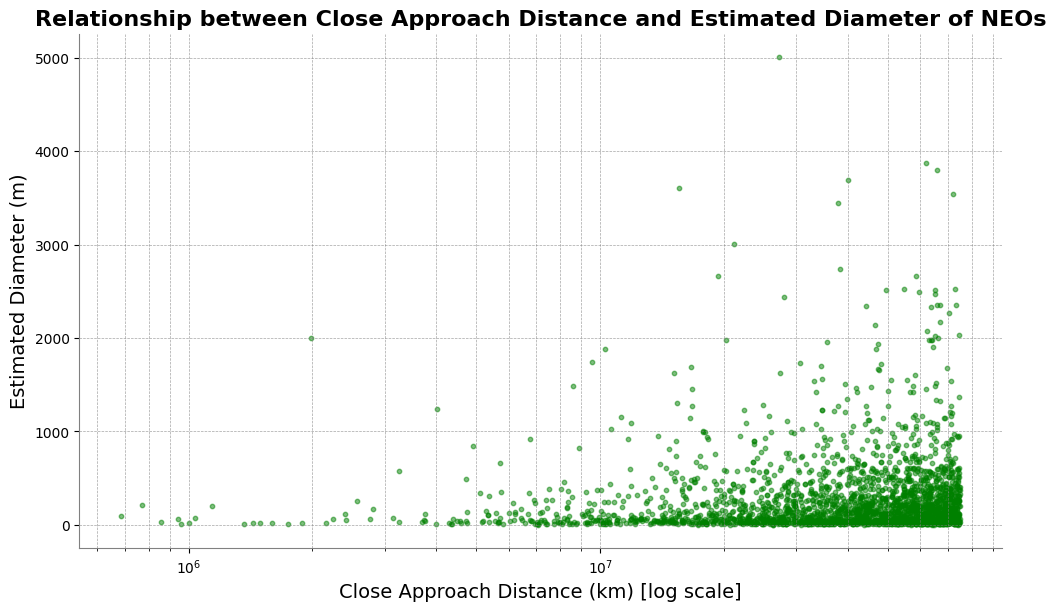

In [25]:
# Write your code
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Used for trend line
import plotly.express as px # Used for interactive visualizations

#Get the count of each potentially_hazardous true and false
df_hazardous_pieChart = pd.DataFrame()
df_hazardous_series = df['potentially_hazardous'].value_counts()
df_hazardous_pieChart = df_hazardous_series.reset_index()
df_hazardous_pieChart.columns = ['potentially_hazardous', 'count']

# Rename cells
df_hazardous_pieChart.at[0, 'potentially_hazardous'] = 'non-hazardous'
df_hazardous_pieChart.at[1, 'potentially_hazardous'] = 'hazardous'

def plot_pie_chart(data, labels_column, values_column, title, colors, explode=None):
    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(
        data[values_column],
        explode=explode,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors
    )

    # Change the color and increase the size of the percentage texts
    for text in autotexts:
        text.set_color('white')  # Change to a color that contrasts well with your pie colors
        text.set_size(10)  # You can adjust the size as needed
        text.set_weight('bold')  # Optional: set to 'bold' for better readability

    # We'll use the 'labels_column' to add the legend to the pie chart.
    ax.legend(
        wedges,
        data[labels_column],
        title="",
        bbox_to_anchor=(1.4, 0.5),
        loc='center right'
    )

    ax.set_aspect('equal')  # Equal aspect ratio ensures that the pie chart is circular
    plt.title(title, fontsize=16, weight='bold')
    plt.show()

# Plot pie chart
colors = ['green', 'red']  # Green for non-hazardous, red for hazardous
title = 'Distribution of Potentially Hazardous vs Non-Hazardous NEOs'
plot_pie_chart(
    df_hazardous_pieChart,
    'potentially_hazardous',
    'count',
    title,
    colors)




# Calculate the average diameter and add it as a new column
df['estimated_diameter_average (m)'] = (df['estimated_diameter_min (m)'] + df['estimated_diameter_max (m)']) / 2
# Turned missed distance values into numeric
df['miss_distance (km)'] = pd.to_numeric(df['miss_distance (km)'], errors='coerce')

def plot_scatter(df, x_column, y_column, color, title, ax, x_label, y_label, trendline=False):
    # Scatter plot
    scatter = ax.scatter(df[x_column], df[y_column], alpha=0.5, color=color, s=10)

    # Optional trend line
    if trendline:
        z = np.polyfit(df[x_column].dropna(), df[y_column].dropna(), 1)
        p = np.poly1d(z)
        ax.plot(df[x_column], p(df[x_column]), color="red", linewidth=1, alpha=0.5, label=f'Linear trend (y={z[0]:.2f}x+{z[1]:.2f})')

    # Logarithmic scale for the x-axis
    ax.set_xscale('log')

    # Enhance readability
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)

    # Clean up the plot - remove gridlines and box border for a cleaner look
    ax.grid(True, which="both", ls="--", lw=0.5, color='gray', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')

    # Include a legend if a trend line is plotted
    if trendline:
        legend = ax.legend(frameon=False, loc='upper left')
        for text in legend.get_texts():
            text.set_color('gray')

# Plot scatterplot
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
title = 'Relationship between Close Approach Distance and Estimated Diameter of NEOs'
plot_scatter(
    df, 'miss_distance (km)',
    'estimated_diameter_average (m)',
    'green',
    title,
    ax,
    'Close Approach Distance (km) [log scale]',
    'Estimated Diameter (m)')

def plot_interactive_scatter(df, x_column, y_column, title, x_label, y_label):
    df[x_column] = pd.to_numeric(df[x_column], errors='coerce')
    df[y_column] = pd.to_numeric(df[y_column], errors='coerce')
    df = df.dropna(subset=[x_column, y_column])

    # Create the interactive scatter plot with Plotly Express
    fig = px.scatter(df, x=x_column, y=y_column, log_x=True, color_discrete_sequence=['green'],
                     title=title, labels={x_column: x_label, y_column: y_label})

    # Improve layout for better readability
    fig.update_layout(
        legend_title_text='Legend',
        plot_bgcolor='white',
        xaxis=dict(
            title=x_label,
            linecolor='black',
            showgrid=False,
            gridcolor='LightGrey',
            gridwidth=0.5,
        ),
        yaxis=dict(
            title=y_label,
            linecolor='black',
            showgrid=True,
            gridcolor='LightGrey',
            gridwidth=0.5,
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    # Update marker size and opacity for better visibility
    fig.update_traces(marker=dict(size=8, opacity=0.7))

    # Add interactive note
    fig.add_annotation(
        text="Interactive: Hover over data points for more information.",
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0,
        y=1.07,
        bordercolor='black',
        borderwidth=1
    )

    # Show the plot
    fig.show()

# Plot interactive scatterplot
plot_interactive_scatter(
    df,
    'miss_distance (km)',
    'estimated_diameter_average (m)',
    'Relationship between Close Approach Distance and Estimated Diameter of NEOs',
    'Close Approach Distance (km) [log scale]',
    'Estimated Diameter (m)'
    )

def plot_interactive_histogram(df, column, title, x_label):
    # Convert the column to numeric and drop NaN values
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(subset=[column])

    # Calculate the 95th percentile value
    percentile_95 = df[column].quantile(0.95)

    # Cap values at the 95th percentile
    df[column] = np.where(df[column] > percentile_95, percentile_95, df[column])

    # Create the histogram with Plotly Express
    fig = px.histogram(df, x=column, nbins=50, title=title)

    # Custom layout adjustments
    fig.update_layout(
        plot_bgcolor='white',  # Set the background color to white
        xaxis=dict(
            title=x_label,
            linecolor='black',
            showgrid=True,
            gridcolor='LightGrey',
            gridwidth=0.5,
            fixedrange=True,
        ),
        yaxis=dict(
            title='Count',
            linecolor='black',
            showgrid=True,
            gridcolor='LightGrey',
            gridwidth=0.5,
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        ),
        # Add annotation for the last bin
        annotations=[
            dict(
                x=percentile_95,
                y=0,
                xref="x",
                yref="paper",
                text="All data above 95th percentile, max size 5000 (m)",
                showarrow=True,
                arrowhead=5,
                ax=-25,
                ay=30
            )
        ]
    )

    # Update the marker color and the line color around the bars
    fig.update_traces(marker_color='RoyalBlue', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.6)

    # Add interactive note
    fig.add_annotation(
        text="Interactive: Hover over bars for more information.",
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0,
        y=1.07,
        bordercolor='black',
        borderwidth=1
    )

    # Show the plot
    fig.show()

# Plot interactive histogram with winsorized data and an annotation
plot_interactive_histogram(
    df,
    'estimated_diameter_average (m)',
    'Distribution of Estimated Diameters of NEOs (Capped at 95th Percentile)',
    'Estimated Diameter (m)'
)


def plot_interactive_box(df, column, title, y_label):
    # Ensure the data type of the column is numeric for Plotly
    df[column] = pd.to_numeric(df[column], errors='coerce')

    # Drop NaN values that could have been introduced during conversion
    df = df.dropna(subset=[column])

    # Filter out non-positive values for log scale
    df = df[df[column] > 0]

    # Create the interactive box plot with a customized outlier definition
    fig = px.box(
        df,
        y=column,
        title=title,
        labels={column: y_label},
        notched=True,  # Shows the confidence interval around the median
        log_y=True,  # Apply a log scale to the y-axis
        points='suspectedoutliers',  # Show only suspected outliers
    )

    # Improve layout
    fig.update_layout(
        plot_bgcolor='white',  # Set the background color to white
        yaxis=dict(
            title=y_label,
            linecolor='black',
            showgrid=True,
            gridcolor='LightGrey',
            gridwidth=0.5,
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    # Customize the box for better emphasis
    fig.update_traces(boxmean=True,  # Show the mean of the distribution
                      marker=dict(size=2, opacity=0.5),  # Reduce marker size for outliers
                      line=dict(width=2))  # Increase linewidth to emphasize the box

    # Add interactive note
    fig.add_annotation(
        text="Interactive: Hover over the plot for more information.",
        align='left',
        showarrow=False,
        xref='paper',
        yref='paper',
        x=0,
        y=1.07,
        bordercolor='black',
        borderwidth=1
    )

    # Show the plot
    fig.show()

# Plot interactive boxplot with log scale
plot_interactive_box(
    df,
    'estimated_diameter_average (m)',
    'Box Plot of Estimated Diameters of NEOs',
    'Estimated Diameter (m) [log scale]'
    )


### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [26]:
# Write your code




### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.